In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import re
import utilities as ut
import modularised_utils as mut

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 0
np.random.seed(seed)

In [144]:
experiment = 'slc'
setting    = 'gaussian'

if setting == 'gaussian':
    path = f"data/{experiment}/results"

elif setting == 'empirical':
    path = f"data/{experiment}/results_empirical"

saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
ll_interventions = all_data['LLmodel']['intervention_set']
hl_interventions = all_data['HLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [145]:
# Load dictionaries containing the results for each optimization method
if setting == 'gaussian':
    diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

elif setting == 'empirical':
    diroca_results = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
    abslingam_results = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

results_to_evaluate = {}

if setting == 'empirical':
    if abslingam_results:
        first_fold_key = list(abslingam_results.keys())[0]
        for style in abslingam_results[first_fold_key].keys():
            method_name = f"Abs-LiNGAM ({style})"
            new_abslingam_dict = {}
            for fold_key, fold_results in abslingam_results.items():
                if style in fold_results:
                    new_abslingam_dict[fold_key] = {style: fold_results[style]}
            results_to_evaluate[method_name] = new_abslingam_dict
    
    def create_diroca_label(run_id):
        """Parses a run_id and creates a simplified label if epsilon and delta are equal."""
        # Use regular expression to find numbers for epsilon and delta
        matches = re.findall(r'(\d+\.?\d*)', run_id)
        if len(matches) == 2:
            eps, delta = matches
            # If they are the same, use the simplified format
            if eps == delta:
                # Handle integer conversion for clean labels like '1' instead of '1.0'
                val = int(float(eps)) if float(eps).is_integer() else float(eps)
                return f"DIROCA (eps_delta_{val})"
        # Otherwise, or if parsing fails, use the full original name
        return f"DIROCA ({run_id})"

    # Unpack each DIROCA hyperparameter run with the new, clean label
    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        for run_id in diroca_results[first_fold_key].keys():
            method_name = create_diroca_label(run_id) # Use the new helper to create the name
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            results_to_evaluate[method_name] = new_diroca_dict

    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

elif setting == 'gaussian':
    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        diroca_run_ids = list(diroca_results[first_fold_key].keys())

        # create a separate entry for each DIROCA run
        for run_id in diroca_run_ids:
            method_name = f"DIROCA ({run_id})"
            
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                # For each fold grab the data for the current run_id
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            
            results_to_evaluate[method_name] = new_diroca_dict

label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }

label_map_empirical = {
                        'DIROCA (eps_0.328_delta_0.107)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }

if setting == 'empirical':
    results_to_evaluate = {label_map_empirical.get(key, key): value for key, value in results_to_evaluate.items()}

elif setting == 'gaussian':
    results_to_evaluate = {label_map_gaussian.get(key, key): value for key, value in results_to_evaluate.items()}

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")


Methods available for evaluation:
  - GradCA
  - BARYCA
  - DIROCA_4
  - DIROCA_8
  - DIROCA_1
  - DIROCA_2
  - DiRoCA_star


In [137]:
def contaminate_omega_semantic(original_omega, ll_interventions, hl_interventions, 
                                        num_misalignments, seed=None, delta=None, return_changed=False):
    rng = random.Random(seed)
    contaminated_omega = dict(original_omega)

    eligible_ll = [ll for ll in original_omega if ll is not None]
    to_corrupt = rng.sample(eligible_ll, k=min(num_misalignments, len(eligible_ll)))

    changed = 0

    for ll_intervention in to_corrupt:
        original_target = original_omega[ll_intervention]
        ll_complexity = 0 if ll_intervention is None else len(ll_intervention.vv())

        # 1) same complexity, different target
        same = [hl for hl in hl_interventions
                if hl is not None and hl != original_target and len(hl.vv()) == ll_complexity]

        candidates = same

        # 2) fallback: nearest complexity (if needed)
        if not candidates:
            pairs = [(hl, abs(len(hl.vv()) - ll_complexity))
                     for hl in hl_interventions if hl is not None and hl != original_target]
            if pairs:
                min_diff = min(diff for _, diff in pairs)
                # enforce a cap if provided (delta)
                if delta is not None and min_diff > delta:
                    continue  # skip this ll; no near-enough HL target
                candidates = [hl for hl, diff in pairs if diff == min_diff]
            else:
                continue  # no alternative HL at all

        # pick a new target and set
        new_target = rng.choice(candidates)
        if new_target != original_target:
            contaminated_omega[ll_intervention] = new_target
            changed += 1

    if return_changed:
        return contaminated_omega, changed
    return contaminated_omega


def evaluate_omega_contamination(original_omega, ll_interventions, hl_interventions, 
                                contamination_levels, results_to_evaluate, saved_folds, 
                                Dll_samples, Dhl_samples, setting, num_trials, delta):
    """Evaluates omega contamination across different levels."""
    omega_contamination_records = []
    
    for num_misalignments in contamination_levels:
        for trial in range(num_trials):
            contaminated_omega = contaminate_omega_semantic(
                original_omega, ll_interventions, hl_interventions, num_misalignments, 
                seed=seed, delta=delta, return_changed=False
            )
            
            for fold_id, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict.get(f'fold_{fold_id}', {})
                    
                    for run_key, run_data in fold_results.items():
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        errors_per_intervention = []
                        
                        for ll_intervention in ll_interventions:
                            if ll_intervention is None:
                                continue
                                
                            contaminated_hl_intervention = contaminated_omega[ll_intervention]
                            if contaminated_hl_intervention is None:
                                continue
                            
                            Dll_test = Dll_samples[ll_intervention][test_indices]
                            Dhl_test = Dhl_samples[contaminated_hl_intervention][test_indices]
                            
                            if setting == 'gaussian':
                                error = ut.calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                            elif setting == 'empirical':
                                error = ut.calculate_empirical_error(T_learned, Dll_test, Dhl_test)
                            
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        omega_contamination_records.append({
                            'method': method_name,
                            'num_misalignments': num_misalignments,
                            'trial': trial,
                            'fold': fold_id,
                            'error': avg_error
                        })
    
    return omega_contamination_records

In [138]:
# contamination_levels = [20] 
# Get total number of interventions
total_interventions  = len([ll for ll in omega if ll is not None])
percentages          = [1.0] #[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
contamination_levels = [int(total_interventions * p) for p in percentages]

num_trials = 100
deltas = [1] #[0, 1, 2]

In [139]:
for delta in deltas:
    # Run omega contamination evaluation
    omega_contamination_records = evaluate_omega_contamination(
        omega, ll_interventions, hl_interventions, contamination_levels, 
        results_to_evaluate, saved_folds, Dll_samples, Dhl_samples, setting, num_trials, delta
    )

    # Convert to DataFrame
    omega_contamination_df = pd.DataFrame(omega_contamination_records)

    # Generate final comparison table
    print("=== OMEGA CONTAMINATION EVALUATION RESULTS ===")
    print("="*60)

    # Overall performance summary
    overall_performance = omega_contamination_df.groupby('method')['error'].agg(['mean', 'std']).round(2)
    overall_performance = overall_performance.sort_values('mean')
    overall_performance.columns = ['Mean Error', 'Std Error']

    print("Overall Performance (All Contamination Levels):")
    print("="*60)
    for method, row in overall_performance.iterrows():
        print(f"{method:<15} | {row['Mean Error']:6.2f} ± {row['Std Error']:5.2f}")

=== OMEGA CONTAMINATION EVALUATION RESULTS ===
Overall Performance (All Contamination Levels):
DIROCA_2        |   5.55 ±  0.03
GradCA          |   5.63 ±  0.03
BARYCA          |   5.86 ±  0.03
DiRoCA_star     |   6.08 ±  0.03
DIROCA_4        |   6.86 ±  0.02
DIROCA_8        |   6.86 ±  0.02
DIROCA_1        |   7.16 ±  0.03


In [140]:
from scipy import stats

def test_significance(omega_contamination_df):
    """Perform paired t-tests to compare methods."""
    
    # Get overall performance ranking
    overall_performance = omega_contamination_df.groupby('method')['error'].agg(['mean', 'std']).round(2)
    overall_performance = overall_performance.sort_values('mean')
    
    best_method = overall_performance.index[0]
    best_errors = omega_contamination_df[omega_contamination_df['method'] == best_method]['error'].values
    
    print(f"Best method: {best_method}")
    print(f"Mean error: {overall_performance.loc[best_method, 'mean']:.2f}")
    
    print(f"\nPaired t-tests ({best_method} vs others):")
    print("="*60)
    
    for method in overall_performance.index[1:]:
        other_errors = omega_contamination_df[omega_contamination_df['method'] == method]['error'].values
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(best_errors, other_errors)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt((np.var(best_errors) + np.var(other_errors)) / 2)
        cohens_d = (np.mean(best_errors) - np.mean(other_errors)) / pooled_std
        
        significance = "Significant" if p_value < 0.05 else "Not Significant"
        
        print(f"{best_method} vs {method:<12} | p={p_value:.4f} | d={cohens_d:.3f} | {significance}")

# Run significance testing
test_significance(omega_contamination_df)

Best method: DIROCA_2
Mean error: 5.55

Paired t-tests (DIROCA_2 vs others):
DIROCA_2 vs GradCA       | p=0.0000 | d=-3.191 | Significant
DIROCA_2 vs BARYCA       | p=0.0000 | d=-11.271 | Significant
DIROCA_2 vs DiRoCA_star  | p=0.0000 | d=-19.026 | Significant
DIROCA_2 vs DIROCA_4     | p=0.0000 | d=-49.614 | Significant
DIROCA_2 vs DIROCA_8     | p=0.0000 | d=-49.614 | Significant
DIROCA_2 vs DIROCA_1     | p=0.0000 | d=-52.859 | Significant


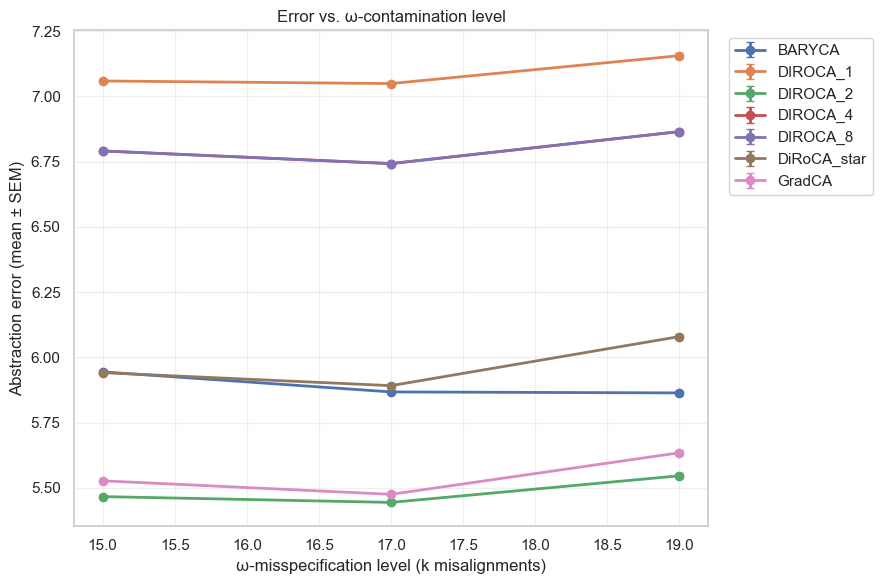

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = omega_contamination_df.copy()

# 1) Pick the column that encodes the contamination level
level_col = 'num_misalignments' if 'num_misalignments' in df.columns else 'contamination_level'
# (Optional) if you also tracked achieved changes, prefer those:
if 'achieved_changes' in df.columns:
    level_col = 'achieved_changes'

# 2) Aggregate per method and contamination level
grp = (df
       .groupby(['method', level_col])['error']
       .agg(['mean','std','count'])
       .reset_index())
grp['sem'] = grp['std'] / np.sqrt(grp['count'])

# 3) Plot lines with error bars
plt.figure(figsize=(9,6))
for method in sorted(grp['method'].unique()):
    sub = grp[grp['method'] == method].sort_values(level_col)
    plt.errorbar(sub[level_col], sub['mean'], yerr=sub['sem'],
                 marker='o', linewidth=2, capsize=3, label=method)

plt.xlabel('ω-misspecification level (k misalignments)')
plt.ylabel('Abstraction error (mean ± SEM)')
plt.title('Error vs. ω-contamination level')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


## ω contamination

In [52]:
def contaminate_omega_map(original_omega, num_misalignments):
    
    """Randomly re-wires a subset of entries in the omega map."""
    
    # omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_keys = [k for k in original_omega.keys()]
    # omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k]]

    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))

    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [53]:
max_misalignments = len(I_ll_relevant) 
misalignment_levels = range(0, max_misalignments)

# Number of random contaminations to average over for each setting
num_trials = 10

omega_spec_records = []
print("Omega-misspecification evaluation")

for num_misalignments in tqdm(misalignment_levels, desc="Misalignment Level"):
    for trial in range(num_trials):
        rng_seed = 10_000 * num_misalignments + trial
        random.seed(rng_seed)
        np.random.seed(rng_seed % (2**32 - 1))  

        # Create a new scrambled omega map
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                #print(method_name)
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():
                    #print(run_data,'\n')
                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name

                    T_learned = run_data['T_matrix']
                    # print(T_learned)
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        if setting == 'gaussian':
                            error = ut.calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        elif setting == 'empirical':
                            error = ut.calculate_empirical_error(T_learned, Dll_test, Dhl_test)
                            
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    record = {
                                'method': method_label, 
                                'misalignments': num_misalignments,
                                'trial': trial,
                                'fold': i,
                                'error': avg_error
                            }
                    omega_spec_records.append(record)

omega_spec_df = pd.DataFrame(omega_spec_records)
print("\n\n--- Omega-Misspecification Evaluation Complete ---")


Omega-misspecification evaluation


Misalignment Level: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]



--- Omega-Misspecification Evaluation Complete ---


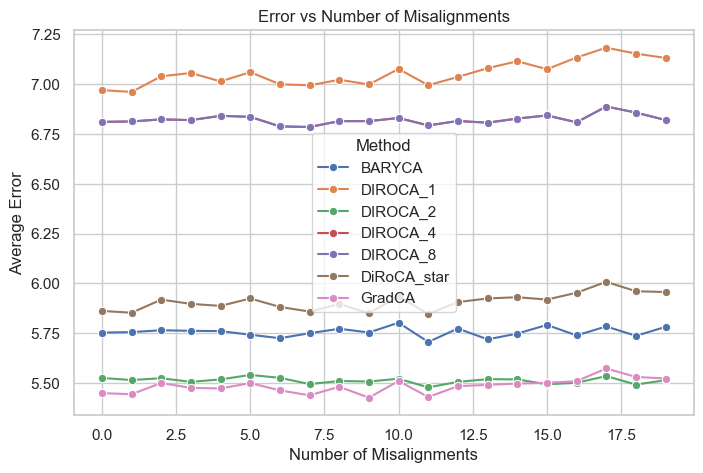

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by method and misalignment count, then average error
summary_df = (
    omega_spec_df
    .groupby(['method', 'misalignments'], as_index=False)['error']
    .mean()
)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=summary_df,
    x="misalignments",
    y="error",
    hue="method",
    marker="o"
)
plt.xlabel("Number of Misalignments")
plt.ylabel("Average Error")
plt.title("Error vs Number of Misalignments")
plt.legend(title="Method")
plt.grid(True)
plt.show()


In [55]:
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']


for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean ± Std
GradCA                              | 5.4856 ± 0.1145
DIROCA_2                            | 5.5130 ± 0.0526
BARYCA                              | 5.7566 ± 0.0912
DiRoCA_star                         | 5.9089 ± 0.1239
DIROCA_4                            | 6.8217 ± 0.0847
DIROCA_8                            | 6.8217 ± 0.0847
DIROCA_1                            | 7.0545 ± 0.1382


In [60]:
# Paired t-tests for contamination analysis
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Get the best method (lowest mean error)
best_method = summary['mean'].idxmin()
best_mean = summary.loc[best_method, 'mean']

print(f"\nBest method: {best_method} (mean error: {best_mean:.4f})")
print("\nPaired t-tests (best vs others):")
print("="*60)

# Get data for best method
best_data = omega_spec_df[omega_spec_df['method'] == best_method]['error'].values

# Compare against all other methods
for method in summary.index:
    if method != best_method:
        other_data = omega_spec_df[omega_spec_df['method'] == method]['error'].values
        
        # Ensure same number of observations for paired test
        min_len = min(len(best_data), len(other_data))
        if min_len > 0:
            t_stat, p_value = ttest_rel(best_data[:min_len], other_data[:min_len])
            other_mean = summary.loc[method, 'mean']
            diff = best_mean - other_mean
            
            print(f"{best_method} vs {method:<30} | p={p_value:.4f} | diff={diff:.4f} | {'Significant' if p_value < 0.05 else 'Not significant'}")
        else:
            print(f"{best_method} vs {method:<30} | No data available")



Best method: GradCA (mean error: 5.4874)

Paired t-tests (best vs others):
GradCA vs BARYCA                         | p=0.0000 | diff=-0.2667 | Significant
GradCA vs DIROCA_1                       | p=0.0000 | diff=-1.5899 | Significant
GradCA vs DIROCA_2                       | p=0.0086 | diff=-0.0284 | Significant
GradCA vs DIROCA_4                       | p=0.0000 | diff=-1.3207 | Significant
GradCA vs DIROCA_8                       | p=0.0000 | diff=-1.3207 | Significant
GradCA vs DiRoCA_star                    | p=0.0000 | diff=-0.4273 | Significant


In [130]:
import random
import pandas as pd
from tqdm import tqdm

# ======================================================================
# 1. The Corrected Helper Function
# ======================================================================
def contaminate_omega_map(original_omega, num_misalignments, seed=None):
    """
    Randomly re-wires a subset of entries in the omega map using a specific seed
    for reproducible randomness.
    """
    # Create a local random number generator for this specific run
    rng = random.Random(seed)
    
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]

    contaminated_omega = original_omega.copy()
    
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Use the local generator for sampling
    to_corrupt = rng.sample(omega_keys, k=num_to_corrupt)
    
    all_targets = list(set(omega_vals))

    for key in to_corrupt:
        original_target = original_omega[key]
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            # Use the local generator for choice
            new_target = rng.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

# ======================================================================
# 2. The Corrected Evaluation Loop
# ======================================================================
max_misalignments = len(I_ll_relevant) -1
misalignment_levels = np.linspace(0, max_misalignments, 11, dtype=int)
num_trials = 3 # You can now increase this to get variance

omega_spec_records = []
print("Omega-misspecification evaluation")

for num_misalignments in tqdm(misalignment_levels, desc="Misalignment Level"):
    for trial in range(num_trials):
        
        # --- THIS IS THE FIX ---
        # Pass the trial number as the seed to get a different map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments, seed=trial)
        # --- END OF FIX ---
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():

                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        if setting == 'gaussian':
                            error = ut.calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        elif setting == 'empirical':
                            error = ut.calculate_empirical_error(T_learned, Dll_test, Dhl_test)
                            
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan

                    record = {
                        'method': method_name, 
                        'misalignments': num_misalignments,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    omega_spec_records.append(record)

omega_spec_df = pd.DataFrame(omega_spec_records)
print("\n\n--- Omega-Misspecification Evaluation Complete ---")

Omega-misspecification evaluation


Misalignment Level: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]



--- Omega-Misspecification Evaluation Complete ---


In [131]:
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']


for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean ± Std
GradCA                              | 311.3339 ± 2.8196
DIROCA_4                            | 312.8305 ± 8.0162
DIROCA_8                            | 313.0358 ± 8.1734
DIROCA_2                            | 316.7920 ± 8.1246
DIROCA_1                            | 334.2950 ± 3.5959
Abslin_n                            | 355.6131 ± 2.4828
Abslin_p                            | 400.4104 ± 2.6991
DiRoCA_star                         | 470.9156 ± 4.0462
BARYCA                              | 561.7603 ± 3.8158
